
# **Cuaderno de Proyecto — Ciencia de Datos con YouTube**
**Curso:** SINT-200  
**Profesor:** Dr. Tomás de Camino Beck  
**Estudiante(s):** _Bernal Rojas Villalobos_  
**Fecha de entrega:** 21 de Octubre

---

## Instrucciones Generales

Reto: Exportar datos de tu actividad YouTube (Google Takeout), construir una matriz usuario-contenido con señales (vistas, likes, tiempo, etc.), hacer EDA de sesgos/“burbujas”, y entrenar dos recomendadores (colaborativo vs. basado en contenido). Comparar métricas (cosas como precision@k, recall@k, cobertura) y explicar errores.  



Este cuaderno sirve como **especificación y entregable** del proyecto. Debes completar cada sección marcada con **TODO** y dejar celdas de código **ejecutables** y **reproducibles**. El reto tiene dos proyectos:

1. **Proyecto 1 — Tu Huella YouTube: Recomendador y Análisis de Burbuja Algorítmica.**  
2. **Proyecto 2 — Detección de “Doomscrolling”: Predicción de sesiones extendidas.**

### Ética y Privacidad de Datos
- Puedes **anonimizar** tu información de YouTube (IDs, títulos, canales, tiempos) antes de subirla aquí.  
- Alternativamente, puedes usar datos de otra persona **con su consentimiento informado** y **anonimizados**.  
- No incluyas PII (información personal identificable) ni material sensible.  
- Incluye un **Anexo de Privacidad** explicando qué datos usaste, cómo los obtuviste y cómo los protegiste.

### Entregables
- Este **cuaderno de Colab** completo y ejecutable.  
- Carpeta `data/` con **muestras** de los datos (o datos sintéticos/anonimizados).  
- **Diccionario de datos** (descripción de campos, tipos, unidades, supuestos).  
- **Resultados y visualizaciones** dentro del notebook.  
- **Conclusiones** + **Recomendaciones** (acciones sugeridas) + **Limitaciones** + **Trabajo futuro**.
- Repositorio con estructura mínima:  
  ```
  README.md
  data/        # muestras o datos anonimizados
  notebooks/   # este cuaderno
  src/         # funciones reutilizables
  reports/     # figuras / tablas clave
  ```

### Rúbrica (100 pts)
- **Charter/Problema y utilidad (10 pts)**: objetivos claros, hipótesis, valor para el usuario.  
- **Adquisición y calidad de datos (10 pts)**: trazabilidad, permisos, limpieza básica.  
- **EDA y visualizaciones (20 pts)**: distribución, outliers, correlaciones, sesgos/segmentos.  
- **Baselines y metodología (10 pts)**: definición de referencia simple y por qué.  
- **Modelado (20 pts)**: al menos **2 enfoques** comparados, justificación.  
- **Evaluación (15 pts)**: métricas adecuadas, validación (temporal cuando aplique), error analysis.  
- **Reproducibilidad (5 pts)**: semillas, funciones, estructura clara.  
- **Conclusiones & ética (10 pts)**: hallazgos accionables y reflexiones de privacidad/sesgo.

---



## 0. Preparación del entorno (ejecutar una vez)


In [1]:
# Clonar tu repositorio
!git clone https://github.com/brojas7/AnaliticaHistorialYoutube.git

# Ir al directorio del proyecto
%cd AnaliticaHistorialYoutube

# TODO: Ajusta versiones si lo necesitas. Evita dependencias innecesarias.
!pip -q install pandas numpy matplotlib scikit-learn textblob python-dateutil tqdm dateparser google-generativeai  gensim

Cloning into 'AnaliticaHistorialYoutube'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 126 (delta 6), reused 0 (delta 0), pack-reused 110 (from 1)
Receiving objects: 100% (126/126), 45.05 MiB | 7.65 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (9/9), done.
/content/AnaliticaHistorialYoutube
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.2 MB/s eta 0:00:00


In [2]:
# Imports base y configuración
import os, json, math, random, itertools, collections, gzip, re, string, time, zipfile, io
from datetime import datetime, timedelta
from dateutil import parser as dateparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)

import sys
sys.path.append('/content/AnaliticaHistorialYoutube/src')

from youtube_utils import load_watch_history, anonymize_df, sessionize

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 200)

print("Entorno listo. Versión de pandas:", pd.__version__)


Entorno listo. Versión de pandas: 2.2.2



## 1. Anexo de Privacidad y Origen de Datos (obligatorio)
**TODO:** Explicar:
- Fuente de datos (Google Takeout, exportación manual, datos de tercero con consentimiento, etc.).  
- Estrategia de **anonimización** (por ejemplo: hashing de IDs/URLs, truncado de timestamps, agrupación por hora/día).  
- Contenido eliminado o agregado (p. ej., datos sintéticos para completar campos).  
- Limitaciones y riesgos residuales.



## 2. Selección de Proyecto
**Marca con una X**

- [ ] **Proyecto 1 — Recomendador YouTube & Burbuja Algorítmica**  
- [ ] **Proyecto 2 — Detección de Doomscrolling (clasificación temporal)**



## 3. Utilidades comunes para YouTube (ingesta y parsing)

Para **Proyecto 1** y **Proyecto 2** puedes usar datos de **Google Takeout**:  
- `watch-history.json` (o `watch-history.html` en exportaciones antiguas)  
- `search-history.json` (opcional)  
- `likes.csv` / `subscriptions.csv` (según disponibilidad)

> **Nota:** Los formatos de Takeout pueden cambiar con el tiempo. Ajusta el parser según tu exportación.



# **Limpieza, Enriquecimiento y Transformación del dataset**


In [ ]:
# Ejemplo de uso
df_search = load_watch_history('data/historial-de-búsqueda.json')
df_watch = load_watch_history('data/historial-de-reproducciones.json')
df_suscipciones = pd.read_csv('data/suscripciones.csv')

#df = anonymize_df(df)
#df = sessionize(df)
print(df_search.shape)
print(df_watch.shape)
print("Eventos:", len(df_watch), "Rango:", df_watch['timestamp'].min(), "->", df_watch['timestamp'].max())

In [ ]:
# Copia base
df_watch_clean = df_watch.copy()

# Limpieza del título (remover "Has visto")
df_watch_clean['video_title'] = df_watch_clean['title'].str.replace(r'^Has visto\s+', '', regex=True)

# Convertir timestamps
df_watch_clean['watched_at'] = pd.to_datetime(df_watch_clean['timestamp'], utc=True)

# Variables derivadas
df_watch_clean['weekday'] = df_watch_clean['watched_at'].dt.day_name()
df_watch_clean['hour'] = df_watch_clean['watched_at'].dt.hour
df_watch_clean['hour_group'] = pd.cut(df_watch_clean['hour'],
                                      bins=[-1,6,12,18,24],
                                      labels=['madrugada','mañana','tarde','noche'])

In [ ]:
df_suscripciones_clean = df_suscipciones.rename(columns={
    "Título del canal": "channel_title",
    "URL del canal": "channel_url",
    "ID del canal": "channel_id"
})

In [ ]:
df_search_clean = df_search.copy()
df_search_clean['timestamp'] = pd.to_datetime(df_search_clean['timestamp'], utc=True)
df_search_clean['search_terms'] = df_search_clean['title'].str.replace('Buscaste', '').str.strip()

Enlace entre vistas y suscripciones

In [ ]:
# Renombramos la columna 'channel' en el historial para igualarla con suscripciones
df_watch_clean = df_watch_clean.rename(columns={'channel': 'channel_title'})

df_main = df_watch_clean.merge(
    df_suscripciones_clean[['channel_title', 'channel_id']],
    on='channel_title',
    how='left',
    indicator=True
)

df_main['is_subscribed'] = (df_main['_merge'] == 'both').astype(int)
df_main.drop(columns=['_merge'], inplace=True)

3️Señales de interacción (para matriz usuario–contenido)

In [ ]:
df_main['interaction_score'] = 1.0
df_main.loc[df_main['is_subscribed'] == 1, 'interaction_score'] += 0.5

Valores nulos en canal
son anuncios i videos borrados

In [ ]:
df_main.shape

In [ ]:
df_main[df_main['channel_title'].isna()][['video_title', 'url']].head(10)


In [ ]:
mask_valid = df_main['channel_title'].notna() & ~df_main['video_title'].str.contains("anuncio", case=False, na=False)
df_main_clean = df_main[mask_valid].copy()

In [ ]:
df_ads = df_main[~mask_valid]
df_ads.to_csv("data/df_ads_removed.csv", index=False)

ANON


# **Proyecto 1 — Tu Huella YouTube: Recomendador & Burbuja Algorítmica**

### Objetivo
1) Construir **dos recomendadores** con tus datos de visualización:  
   - **Baseline de popularidad** (o popularidad por canal/categoría).  
   - **Modelo basado en contenido** (TF‑IDF/embeddings por título/canal) **o** **colaborativo** (si tienes interacciones de múltiples usuarios/fuentes).  
2) Medir **Precision@k, Recall@k y Coverage** (y *diversidad*) en un esquema **offline**.  
3) Analizar posibles **sesgos o “burbujas”** (temas/canales dominantes por hora, día, duración).  

### Requisitos mínimos
- **EDA**: distribución de vistas por canal, hora del día, día de semana, duración de sesiones, *top‑k* temas.  
- **Ingeniería de features** (ej.: tokenización títulos, lematización opcional, normalización de canales).  
- **Comparación de al menos 2 enfoques** de recomendación.  
- **Evaluación offline** con *train/test split temporal*.  
- **Análisis de errores** y discusión de sesgos/limitaciones.

---

## 4. Charter del Proyecto 1 (llenar)
**TODO:** Define el propósito, preguntas clave y utilidad (qué decisiones permitirán tus hallazgos).



## 5. Carga de datos (Proyecto 1)
**TODO:** Sube tu `watch-history.json` (anonimizado si aplica) a `data/` y cárgalo.


In [3]:
df_main = pd.read_csv("data/df_enrich_enriquecido.csv")
print(df_main.shape)
df_main.head()

(31217, 18)


,timestamp,title,channel_title,channel_id_x,video_id,url,video_title,watched_at,weekday,hour,hour_group,channel_id_y,is_subscribed,interaction_score,category,subtopic,format,keywords
0,2018-02-22 02:05:35.427000+00:00,Has visto La canción más hermosa en piano fáci...,Paula Yessenia Barragan Izquierdo,NaN,ro1rC9dL5EQ,https://www.youtube.com/watch?v=ro1rC9dL5EQ,La canción más hermosa en piano fácil de aprender,2018-02-22 02:05:35.427000+00:00,Thursday,2,madrugada,NaN,0,1.0,Tutorial,Music Lesson,Tutorial,"['piano', 'easy to learn', 'music lesson']"
1,2018-02-22 03:49:54.096000+00:00,Has visto Ed Sheeran - Perfect - EASY Piano Tu...,Peter PlutaX,NaN,p1WCR7vNcIw,https://www.youtube.com/watch?v=p1WCR7vNcIw,Ed Sheeran - Perfect - EASY Piano Tutorial by ...,2018-02-22 03:49:54.096000+00:00,Thursday,3,madrugada,NaN,0,1.0,Tutorial,Music Lesson,Tutorial,"['Ed Sheeran', 'Perfect', 'piano tutorial', 'e..."
2,2018-02-22 05:27:06.367000+00:00,Has visto How I proposed: fairytale story with...,bigchewypretzels,NaN,Srw9gXDa24g,https://www.youtube.com/watch?v=Srw9gXDa24g,How I proposed: fairytale story with puzzles a...,2018-02-22 05:27:06.367000+00:00,Thursday,5,madrugada,NaN,0,1.0,Entertainment,Relationship/Life Event,Vlog/Storytelling,"['proposal', 'love story', 'fairytale', 'relat..."
3,2018-02-22 06:26:38.438000+00:00,Has visto TOP 5 BROMAS - Bromas para hacer a t...,BROMAS Y MÁS TVOAQUI,NaN,Q4UilByqMTc,https://www.youtube.com/watch?v=Q4UilByqMTc,"TOP 5 BROMAS - Bromas para hacer a tus amigos,...",2018-02-22 06:26:38.438000+00:00,Thursday,6,madrugada,NaN,0,1.0,Entertainment,Comedy/Prank,Prank Compilation,"['pranks', 'friends', ""Valentine's Day"", 'come..."
4,2018-02-22 14:20:32.963000+00:00,Has visto Morat - Yo Más Te Adoro,MoratVEVO,NaN,pqJBXjzBr_U,https://www.youtube.com/watch?v=pqJBXjzBr_U,Morat - Yo Más Te Adoro,2018-02-22 14:20:32.963000+00:00,Thursday,14,tarde,NaN,0,1.0,Music,Music Performance,Official Music Video,"['Morat', 'Yo Más Te Adoro', 'Latin Pop', 'Off..."


In [4]:
import hashlib
import pandas as pd
import numpy as np

def hash_value(x):
    """Aplica hash SHA-256 truncado (12 chars) a cualquier valor."""
    if pd.isna(x):
        return np.nan
    return hashlib.sha256(str(x).encode()).hexdigest()[:12]

# Copia del dataframe original
df_hashed = df_main.copy()

# Aplica el hash a todo el dataframe
df_hashed = df_hashed.applymap(hash_value)

# Verifica resultado
df_hashed.head()

/tmp/ipython-input-359848926.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashed = df_hashed.applymap(hash_value)


,timestamp,title,channel_title,channel_id_x,video_id,url,video_title,watched_at,weekday,hour,hour_group,channel_id_y,is_subscribed,interaction_score,category,subtopic,format,keywords
0,43b624cafb0c,b5c2fe6c821d,561cc3b6b7fb,NaN,d8b7eb145254,5b328611dfd1,7f78ca26e123,43b624cafb0c,fc2662062ffd,d4735e3a265e,c420fdb9ac10,NaN,5feceb66ffc8,d0ff5974b6aa,c26982b1425d,1ecbd27cfc92,c26982b1425d,1dc189d46c1d
1,ac49439f1641,9267aa5a5ce2,bc5af354f824,NaN,7e655fd0d398,2aed642c7f9d,11eaa6ac0ea2,ac49439f1641,fc2662062ffd,4e07408562be,c420fdb9ac10,NaN,5feceb66ffc8,d0ff5974b6aa,c26982b1425d,1ecbd27cfc92,c26982b1425d,405ab863bc17
2,aa80c41676a7,5035d49868e3,07254e8fb92b,NaN,585412c8f79b,3688faaf95fb,d954a349049f,aa80c41676a7,fc2662062ffd,ef2d127de37b,c420fdb9ac10,NaN,5feceb66ffc8,d0ff5974b6aa,ceaa553e838f,4fae335077e6,200fafff5b00,c75c87529646
3,d6273362f33c,bc92ec09f80c,b03d217c9070,NaN,ad81fdd792ac,0d89a0111957,77d86ffa77c6,d6273362f33c,fc2662062ffd,e7f6c011776e,c420fdb9ac10,NaN,5feceb66ffc8,d0ff5974b6aa,ceaa553e838f,d63b6b556ce7,ff14d2076ecc,3edeeb3b1efd
4,52c804da8e4d,f0f24a0474ac,0f66b5b56794,NaN,4e7403885505,018b4f680689,c13793508e6c,52c804da8e4d,fc2662062ffd,8527a891e224,dfc02909a308,NaN,5feceb66ffc8,d0ff5974b6aa,6eb00b4b2614,9423a442e22b,754dc3f10982,f642e0d4921f



## 6. EDA (Proyecto 1)
**TODO:** Explora sesgos por canal/tema/horario. Muestra tablas y gráficos clave.


In [5]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
import ast
import pandas as pd

def str_to_list(column):
    """
    Convierte una columna de strings con formato de lista en listas reales.
    Ejemplo: "['piano', 'easy to learn']" -> ['piano', 'easy to learn']

    Parámetros:
        column (pd.Series): Columna de un DataFrame.

    Retorna:
        pd.Series: Columna convertida a listas reales.
    """
    def safe_eval(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        elif isinstance(x, list):
            return x
        else:
            return []

    return column.apply(safe_eval)

In [7]:
# Ejemplo con tu DataFrame
df_main["keywords"] = str_to_list(df_main["keywords"])

In [8]:
def get_text_vector(text, model):
    """
    Promedia los embeddings de las palabras de un texto (frase o lista).
    Devuelve vector 300D.
    """
    if isinstance(text, list):
        tokens = text
    elif isinstance(text, str):
        tokens = text.lower().split()
    else:
        tokens = []

    valid_vectors = [model[w] for w in tokens if w in model]
    if not valid_vectors:
        return np.zeros(model.vector_size)
    return np.mean(valid_vectors, axis=0)


def get_keyword_vectors(keyword_list, model):
    """
    Convierte lista de keywords (palabras o frases) en lista de vectores (300D).
    Tokeniza correctamente y maneja mayúsculas/minúsculas.
    """
    vectors = []
    if not isinstance(keyword_list, list):
        return []

    for kw in keyword_list:
        if not isinstance(kw, str):
            continue

        tokens = kw.split()  # divide frases tipo "easy to learn"
        token_vectors = []

        for token in tokens:
            # Buscar distintas capitalizaciones
            if token in model:
                token_vectors.append(model[token])
            elif token.capitalize() in model:
                token_vectors.append(model[token.capitalize()])
            elif token.upper() in model:
                token_vectors.append(model[token.upper()])

        # Promedia las palabras de la frase
        if token_vectors:
            vectors.append(np.mean(token_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))

    return vectors

# ============================================================
# 🔹 4️⃣ Generar embeddings por columna
# ============================================================

df_embed = df_main.copy()
cols_single_vector = ["category", "subtopic", "format", "video_title", "channel_title"]

print("Generando embeddings columna por columna...")

# Embeddings individuales (vector promedio 300D)
for col in cols_single_vector:
    print(f"→ Procesando {col}")
    df_embed[f"{col}_vec"] = df_embed[col].apply(lambda x: get_text_vector(x, model))

# Embeddings múltiples (lista de vectores 300D por keyword)
print("→ Procesando keywords (lista de vectores)...")
df_embed["keywords_vec"] = df_embed["keywords"].apply(lambda x: get_keyword_vectors(x, model))

print("✅ Embeddings generados exitosamente.")

# ============================================================
# 🔹 5️⃣ Verificación de salida
# ============================================================
cols_to_show = [
    "keywords",
    "category_vec",
    "subtopic_vec",
    "format_vec",
    "video_title_vec",
    "channel_title_vec",
    "keywords_vec"
]

print("\n🔍 Ejemplo de salida:")
display(df_embed[cols_to_show].head(5))

Generando embeddings columna por columna...
→ Procesando category
→ Procesando subtopic
→ Procesando format
→ Procesando video_title
→ Procesando channel_title
→ Procesando keywords (lista de vectores)...
✅ Embeddings generados exitosamente.

🔍 Ejemplo de salida:


,keywords,category_vec,subtopic_vec,format_vec,video_title_vec,channel_title_vec,keywords_vec
0,"[piano, easy to learn, music lesson]","[0.13671875, -0.12109375, -0.100097656, -0.042...","[0.14831543, -0.08959961, 0.057739258, 0.00994...","[0.13671875, -0.12109375, -0.100097656, -0.042...","[-0.00730896, -0.015449524, 0.12197876, 0.0943...","[-0.100097656, -0.07861328, 0.07373047, 0.2656...","[[0.15917969, -0.17578125, -0.10449219, -0.066..."
1,"[Ed Sheeran, Perfect, piano tutorial, easy]","[0.13671875, -0.12109375, -0.100097656, -0.042...","[0.14831543, -0.08959961, 0.057739258, 0.00994...","[0.13671875, -0.12109375, -0.100097656, -0.042...","[0.10127767, -0.012736003, -0.0616862, 0.04007...","[0.12988281, 0.1875, -0.095214844, 0.4453125, ...","[[0.12915039, 0.3154297, -0.19726562, 0.077758..."
2,"[proposal, love story, fairytale, relationship]","[0.035888672, -0.096191406, -0.21582031, -0.10...","[-0.020141602, -0.06933594, -0.03564453, 0.054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.057807073, 0.0064154733, -0.017917208, 0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.14355469, 0.025512695, 0.12011719, 0.0546..."
3,"[pranks, friends, Valentine's Day, comedy]","[0.035888672, -0.096191406, -0.21582031, -0.10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11779785, -0.052490234, 0.12548828, 0.09924...","[-0.014133453, -0.011779785, 0.123535156, 0.07...","[-0.08312988, -0.023071289, 0.20361328, 0.2065...","[[0.18945312, 0.15039062, 0.10449219, 0.363281..."
4,"[Morat, Yo Más Te Adoro, Latin Pop, Official M...","[0.03881836, -0.21679688, -0.053466797, 0.0388...","[0.014038086, -0.063964844, -0.0014648438, -0....","[0.053019207, -0.10324097, -0.06339518, -0.006...","[-0.032145184, 0.060221355, 0.13378906, 0.1557...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.24414062, -0.030029297, -0.24023438, -0.33..."


In [9]:
#df_embed.loc[1, "keywords_vec"][1]

In [10]:
del model


## 7. Partición temporal y definición de tareas (Proyecto 1)
**TODO:** Define ventana de entrenamiento y de evaluación para recomendación **offline**.


In [31]:
def get_global_embedding(row, weight_keywords=2.0):
    """
    Combina todos los embeddings (category, subtopic, format, title, channel, keywords)
    en un solo vector promedio ponderado.
    """
    vectors = []

    # columnas simples
    for col in ["category_vec", "subtopic_vec", "format_vec", "video_title_vec", "channel_title_vec"]:
        if isinstance(row[col], np.ndarray) and row[col].any():
            vectors.append(row[col])

    # keywords (lista de vectores)
    if isinstance(row["keywords_vec"], list) and len(row["keywords_vec"]) > 0:
        kw_mean = np.mean(row["keywords_vec"], axis=0)
        vectors.append(kw_mean * weight_keywords)  # ponderamos keywords un poco más

    if len(vectors) == 0:
        return np.zeros(300)

    # promedio de todos los embeddings
    return np.mean(vectors, axis=0)

df_embed["content_vec"] = df_embed.apply(lambda r: get_global_embedding(r), axis=1)

print("✅ Embeddings globales creados:", df_embed["content_vec"].iloc[0].shape)

✅ Embeddings globales creados: (300,)


In [32]:
# Asegurar que timestamp es datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Verifica que la conversión haya funcionado
print(df_embed["timestamp"].dtypes)
print(df_embed["timestamp"].head())

# Split temporal: por ejemplo, último 20% del tiempo como test
cut_ts = df_embed['timestamp'].quantile(0.8)
train = df_embed[df_embed['timestamp'] <= cut_ts].copy()
test  = df_embed[df_embed['timestamp'] >  cut_ts].copy()

print("train:", train['timestamp'].min(), "->", train['timestamp'].max(), "n=", len(train))
print("test :", test['timestamp'].min(),  "->", test['timestamp'].max(),  "n=", len(test))

datetime64[ns, UTC]
0   2018-02-22 02:05:35.427000+00:00
1   2018-02-22 03:49:54.096000+00:00
2   2018-02-22 05:27:06.367000+00:00
3   2018-02-22 06:26:38.438000+00:00
4   2018-02-22 14:20:32.963000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
train: 2018-02-22 02:05:35.427000+00:00 -> 2022-03-10 13:39:19.200000+00:00 n= 24949
test : 2022-03-10 13:40:19.690000+00:00 -> 2025-10-18 01:02:57.606000+00:00 n= 6238



## 8. Baseline de popularidad (Proyecto 1)
Genera recomendaciones **sin personalización** como referencia.


In [37]:

# Top-N por popularidad (baseline)
K = 10  # tamaño de recomendación
top_items = train['video_id'].value_counts().head(100).index.tolist()

def recommend_popularity(k=K):
    return top_items[:k]

# Conjunto de ítems verdaderos en test (lo visto en test)
true_items = set(test['video_id'].dropna().unique().tolist())

def precision_at_k(recommended, true_set):
    if len(recommended) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(recommended)

def recall_at_k(recommended, true_set):
    if len(true_set) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(true_set)

# Eval baseline
rec = recommend_popularity(K)
p = precision_at_k(rec, true_items)
r = recall_at_k(rec, true_items)
coverage = len(set(top_items)) / max(1, df_embed['video_id'].nunique())

print(f"Baseline Popularidad -> P@{K}={p:.3f}  R@{K}={r:.3f}  Cobertura={coverage:.3f}")

Baseline Popularidad -> P@10=0.900  R@10=0.002  Cobertura=0.006



## 9. Recomendador basado en contenido **(ejemplo TF-IDF por título/canal)**
**TODO:** Implementa TF‑IDF (o embeddings) y calcula similitud contenido‑a‑contenido para recomendar.


In [33]:
# ============================================================
# 🔹 1️⃣ Importar librerías
# ============================================================
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# ============================================================
# 🔹 2️⃣ Normalizar los embeddings globales
# ============================================================
# Aseguramos que todos los vectores tengan norma unitaria (para el coseno)
matrix = np.vstack(df_embed["content_vec"].values)
matrix = normalize(matrix)

# Guardamos la versión normalizada dentro del DataFrame (opcional)
df_embed["content_vec_norm"] = list(matrix)

print(f"✅ {len(matrix)} embeddings normalizados. Ejemplo shape:", matrix[0].shape)

# ============================================================
# 🔹 3️⃣ Función de recomendación “lazy”
# ============================================================
def recommend_lazy(video_id, df, top_k=5):
    """
    Recomendador basado en contenido que calcula similitud solo para un video.
    Usa cosine_similarity dinámicamente sin crear una matriz gigante.
    """
    if video_id >= len(df):
        raise ValueError("El índice de video está fuera de rango.")

    # Vector del video objetivo
    target_vec = df.iloc[video_id]["content_vec_norm"].reshape(1, -1)

    # Matriz con todos los embeddings normalizados
    matrix = np.vstack(df["content_vec_norm"].values)

    # Similaridad coseno entre el video elegido y todos los demás
    sim_scores = cosine_similarity(target_vec, matrix).flatten()

    # Ordenar por similitud descendente (excluyendo el mismo video)
    top_indices = np.argsort(sim_scores)[::-1][1:top_k+1]

    # Resultado
    result = df.iloc[top_indices][["video_title", "category", "subtopic", "channel_title", "timestamp"]].copy()
    result["similarity"] = sim_scores[top_indices]
    return result

✅ 31217 embeddings normalizados. Ejemplo shape: (300,)


In [34]:
df_embed.video_title.sample(5)

,video_title
29935,J Balvin - Rio (Official Video)
3303,Shawn Mendes - Youth (Official Lyric Video) ft...
7124,Xantos - Bailame Despacio (feat. Dynell)
795,"Duele, Dama - bachata (letra)"
24412,Daddy Yankee x Myke Towers - Pasatiempo (Video...


In [73]:
# ============================================================
# 🔹 4️⃣ Ejemplo de uso
# ============================================================
video_id = 24292 #17259  # prueba con cualquier índice existente
print(f"\n🎬 Video base: {df_embed.loc[video_id, 'video_title']}")
print("🔎 Recomendaciones más similares:")
display(recommend_lazy(video_id, df_embed, top_k=10))


🎬 Video base: Franco Escamilla.- "Opiniones"
🔎 Recomendaciones más similares:


,video_title,category,subtopic,channel_title,timestamp,similarity
24292,"Franco Escamilla.- ""Opiniones""",Comedy,"Stand-up comedy, Humor, Monólogo",Franco Escamilla,2022-03-11 20:49:50.956000+00:00,1.000000
24293,Franco Escamilla.- Asalto y dignidad,Comedy,"Stand-up comedy, Humor, Monólogo",Franco Escamilla,2022-03-11 21:03:54.344000+00:00,0.990201
24238,Franco Escamilla.- monólogo Japón,Comedy,Stand-up,Franco Escamilla,2022-03-02 18:16:36.316000+00:00,0.990156
24236,"Franco Escamilla .- Monólogo ""Miedos""",Comedy,Stand-up,Franco Escamilla,2022-03-02 18:01:40.126000+00:00,0.989120
24289,Franco Escamilla.- Mi vecino cagastian,Comedy,"Stand-up comedy, Humor, Monólogo",Franco Escamilla,2022-03-10 13:37:41.437000+00:00,0.987246
24283,"Franco Escamilla.- ""Medios en Colima"", ""No dis...",Comedy,"Stand-up comedy, Humor, Monólogo",Franco Escamilla,2022-03-08 18:31:08.042000+00:00,0.982718
24239,Franco Escamilla. - Monólogo Colombia,Comedy,Stand-up,Franco Escamilla,2022-03-02 18:51:38.702000+00:00,0.972054
24414,Franco Escamilla.- Diablo Chero,Comedy,Stand-up Comedy,Franco Escamilla,2022-03-25 22:18:58.162000+00:00,0.961970
30961,Franco Escamilla - Monólogo No somos iguales,Comedy,Stand-up Comedy,Franco Escamilla,2022-08-31 18:25:30.759000+00:00,0.960503
24240,Franco Escamilla.- Aprender a disimular,Comedy,Stand-up Comedy,Franco Escamilla,2022-03-02 23:11:21.932000+00:00,0.956384


In [36]:
# ============================================================
# 🔹 1️⃣ Importar librerías
# ============================================================
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# ============================================================
# 🔹 2️⃣ Normalizar embeddings
# ============================================================
train_matrix = np.vstack(train["content_vec"].values)
test_matrix  = np.vstack(test["content_vec"].values)

train_matrix = normalize(train_matrix)
test_matrix  = normalize(test_matrix)

# ============================================================
# 🔹 3️⃣ Calcular similitud entre videos de test y train
# ============================================================
# Similitud coseno entre cada video en test y todos los del train
sim_matrix = cosine_similarity(test_matrix, train_matrix)

print("✅ Matriz de similitud creada:", sim_matrix.shape)
# sim_matrix[i, j] = similitud entre test[i] y train[j]

# ============================================================
# 🔹 4️⃣ Generar recomendaciones desde el conjunto de entrenamiento
# ============================================================
def recommend_for_test_video(i, sim_matrix, train_df, top_k=5):
    """
    Devuelve los top_k videos más similares del train para el video test[i].
    """
    sim_scores = sim_matrix[i]
    top_idx = np.argsort(sim_scores)[::-1][:top_k]
    return train_df.iloc[top_idx]["video_title"].values

# ============================================================
# 🔹 5️⃣ Evaluar Precision@k y Recall@k
# ============================================================
def precision_recall_at_k(train_df, test_df, sim_matrix, k=5):
    """
    Calcula precision@k y recall@k comparando los temas/canales.
    """
    precisions, recalls = [], []

    for i in range(len(test_df)):
        # Videos recomendados
        recs = recommend_for_test_video(i, sim_matrix, train_df, top_k=k)

        # Video real (lo que el usuario realmente vio en test)
        real_video = test_df.iloc[i]

        # Definimos “match” si tienen el mismo canal o categoría
        real_cat = real_video["category"]
        real_channel = real_video["channel_title"]

        matches = train_df[
            (train_df["category"] == real_cat) |
            (train_df["channel_title"] == real_channel)
        ]["video_title"].values

        # precision@k = (# aciertos en recomendaciones) / k
        hits = len(set(recs).intersection(set(matches)))
        precision = hits / k

        # recall@k = (# aciertos en recomendaciones) / (# posibles aciertos)
        recall = hits / len(matches) if len(matches) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# ============================================================
# 🔹 6️⃣ Ejecutar evaluación
# ============================================================
precision, recall = precision_recall_at_k(train, test, sim_matrix, k=5)
print(f"📈 Precision@5: {precision:.3f}")
print(f"📈 Recall@5:    {recall:.3f}")

# ============================================================
# 🔹 7️⃣ Cobertura
# ============================================================
def coverage(sim_matrix, k=5):
    """
    Calcula el porcentaje de videos únicos recomendados.
    """
    rec_indices = [np.argsort(row)[::-1][:k] for row in sim_matrix]
    unique_recs = len(set(np.concatenate(rec_indices)))
    return unique_recs / sim_matrix.shape[1]

print(f"🌍 Coverage@5: {coverage(sim_matrix, k=5):.2%}")

✅ Matriz de similitud creada: (6238, 24949)
📈 Precision@5: 0.652
📈 Recall@5:    0.014
🌍 Coverage@5: 39.66%


Ejecutando t-SNE sobre 3000 puntos...
✅ t-SNE completado
Calculando K-Means para distintos k...


100%|██████████| 13/13 [00:00<00:00, 14.21it/s]


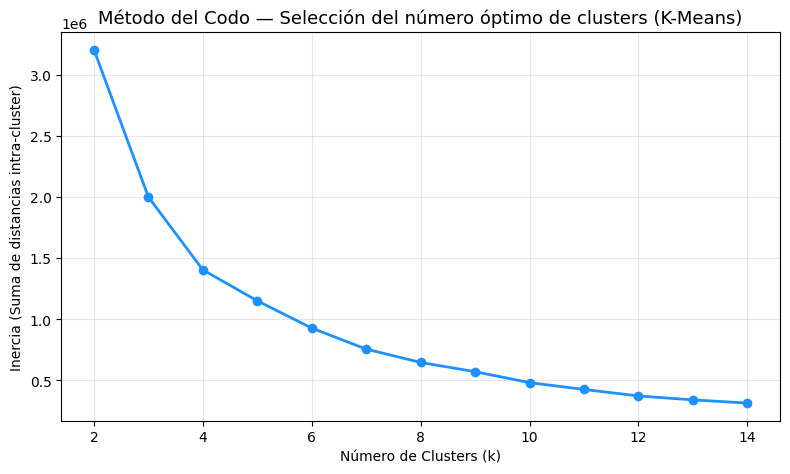

In [43]:
# ============================================================
# 🔹 1️⃣ Importar librerías
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from tqdm import tqdm

# ============================================================
# 🔹 2️⃣ Preparar datos
# ============================================================
max_points = 3000
df_sample = pd.concat([train.assign(set="Train"), test.assign(set="Test")])
df_sample = df_sample.sample(min(len(df_sample), max_points), random_state=42).reset_index(drop=True)

matrix = normalize(np.vstack(df_sample["content_vec"].values))

# ============================================================
# 🔹 3️⃣ Calcular t-SNE
# ============================================================
print(f"Ejecutando t-SNE sobre {matrix.shape[0]} puntos...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    init="random",
    random_state=42
)
tsne_result = tsne.fit_transform(matrix)
df_sample["tsne_1"] = tsne_result[:, 0]
df_sample["tsne_2"] = tsne_result[:, 1]
print("✅ t-SNE completado")

# ============================================================
# 🔹 4️⃣ Método del Codo (Elbow)
# ============================================================
inertias = []
K = range(2, 15)

print("Calculando K-Means para distintos k...")
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sample[["tsne_1", "tsne_2"]])
    inertias.append(kmeans.inertia_)

# ============================================================
# 🔹 5️⃣ Graficar el codo
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(K, inertias, "o-", color="dodgerblue", linewidth=2)
plt.title("Método del Codo — Selección del número óptimo de clusters (K-Means)", fontsize=13)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (Suma de distancias intra-cluster)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [44]:
# ============================================================
# 🔹 4️⃣ K-Means clustering sobre los embeddings t-SNE
# ============================================================
n_clusters = 8  # puedes ajustar este número según tu dataset
print(f"Entrenando K-Means con {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_sample["cluster"] = kmeans.fit_predict(df_sample[["tsne_1", "tsne_2"]])
print("✅ Clustering completado")

# ============================================================
# 🔹 5️⃣ Crear popup con información del video
# ============================================================
df_sample["info_popup"] = (
    "<b>Video:</b> " + df_sample["video_title"].astype(str) +
    "<br><b>Categoría:</b> " + df_sample["category"].astype(str) +
    "<br><b>Subtopic:</b> " + df_sample["subtopic"].astype(str) +
    "<br><b>Canal:</b> " + df_sample["channel_title"].astype(str) +
    "<br><b>Set:</b> " + df_sample["set"].astype(str) +
    "<br><b>Cluster:</b> " + df_sample["cluster"].astype(str)
)

# ============================================================
# 🔹 6️⃣ Visualización interactiva de clusters
# ============================================================
fig = px.scatter(
    df_sample,
    x="tsne_1",
    y="tsne_2",
    color="cluster",
    hover_name="video_title",
    hover_data={"category": True, "channel_title": True},
    title=f"t-SNE + K-Means ({n_clusters} clusters) — Agrupamiento de videos por contenido",
    color_continuous_scale="Turbo",
)

fig.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.4, color="white")),
    customdata=df_sample["info_popup"],
    hovertemplate="%{customdata}"
)

fig.update_layout(
    width=950,
    height=750,
    template="plotly_white",
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

fig.show()

Entrenando K-Means con 8 clusters...
✅ Clustering completado


In [46]:
# ============================================================
# 🔹 1️⃣ Preparar datos temporales
# ============================================================
import pandas as pd
import plotly.express as px
import plotly.colors as pc

# Aseguramos tipo datetime
df_sample["timestamp"] = pd.to_datetime(df_sample["timestamp"], errors="coerce")

# Agrupamos por mes
df_time = (
    df_sample
    .assign(month=df_sample["timestamp"].dt.to_period("M").astype(str))
    .groupby(["month", "cluster"])
    .size()
    .reset_index(name="count")
    .sort_values("month")
)

# ============================================================
# 🔹 2️⃣ Paleta de colores (corregida)
# ============================================================
# Usamos Turbo desde los colores secuenciales
color_scale = pc.sequential.Turbo

# ============================================================
# 🔹 3️⃣ Visualización temporal
# ============================================================
fig = px.line(
    df_time,
    x="month",
    y="count",
    color="cluster",
    title="📈 Evolución temporal del consumo por cluster de contenido",
    markers=True,
    color_discrete_sequence=color_scale,
)

fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Cantidad de videos vistos",
    hovermode="x unified",
    template="plotly_white",
    width=950,
    height=550,
)

fig.show()

/tmp/ipython-input-98406766.py:14: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [48]:
df_sample["timestamp"] = pd.to_datetime(df_sample["timestamp"], errors="coerce")
df_time = (
    df_sample
    .assign(period=df_sample["timestamp"].dt.to_period("Q").astype(str))
    .groupby(["period", "cluster"])
    .size()
    .reset_index(name="count")
)
df_pct = (
    df_time
    .pivot(index="period", columns="cluster", values="count")
    .fillna(0)
    .apply(lambda x: x / x.sum(), axis=1)
    .reset_index()
    .melt(id_vars="period", var_name="cluster", value_name="pct")
)

fig = px.area(
    df_pct,
    x="period",
    y="pct",
    color="cluster",
    title="🌊 Evolución trimestral de consumo por cluster de contenido",
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Trimestre",
    yaxis_title="Proporción de consumo (%)",
    hovermode="x unified",
    width=950, height=500,
    legend_title_text="Cluster temático",
)
fig.update_yaxes(tickformat=".0%")
fig.show()


/tmp/ipython-input-1767450238.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



## PÚRBEA CUSTOM

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Asegúrate:
# - train/test tienen: timestamp (datetime), weekday (0-6 o nombre), hour (0-23)
# - content_vec_norm ya es vector normalizado (len=300)
# - category, subtopic, format, channel_title, is_subscribed, interaction_score están presentes

# --- Utilidades de tiempo (distancia circular -> similitud [0,1]) -----------------
def circular_sim(a, b, period):
    """Similitud circular: 1 si son iguales, 0 si opuestos en el ciclo."""
    # a y b pueden ser escalares o arrays (broadcast)
    delta = np.abs(a - b)
    delta = np.minimum(delta, period - delta)  # distancia mínima en círculo
    # mapear distancia a similitud suave (1 en 0, 0 en period/2)
    # kernel coseno: sim = (1 + cos(pi*delta/(period/2))) / 2
    sim = (1 + np.cos(np.pi * delta / (period / 2))) / 2
    return sim

# --- Preprocesamiento liviano -----------------------------------------------------
def _ensure_weekday_num(s):
    # Convierte nombres a 0-6 si fuera necesario
    if np.issubdtype(s.dtype, np.number):
        return s.astype(int)
    mapper = {n:i for i,n in enumerate(
        ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])}
    return s.map(mapper).astype(int)

for df_ in (train, test):
    # hora (0-23)
    if "hour" not in df_.columns:
        df_["timestamp"] = pd.to_datetime(df_["timestamp"], errors="coerce", utc=True)
        df_["hour"] = df_["timestamp"].dt.hour
    # weekday 0-6
    if "weekday" not in df_.columns:
        df_["weekday"] = df_["timestamp"].dt.weekday
    df_["weekday"] = _ensure_weekday_num(df_["weekday"])

# Apilamos una matriz de embeddings normalizados del train
train_mat = np.vstack(train["content_vec_norm"].values).astype(np.float32)

# --- Similitud compuesta ----------------------------------------------------------
def hybrid_similarities_one(test_row, w=None):
    """
    Calcula similitud del test_row contra TODO el train con una función compuesta.
    Retorna vector (len=train).
    """
    if w is None:
        w = dict(
            text=0.55,
            hour=0.10,
            weekday=0.05,
            channel=0.10,
            category=0.08,
            subtopic=0.07,
            fmt=0.03,
            subscribed_boost=0.02,
            interact_boost=0.00  # lo aplicamos como multiplicador, no suma
        )

    # --- Texto (coseno) ---
    q = test_row["content_vec_norm"].reshape(1, -1).astype(np.float32)
    s_text = cosine_similarity(q, train_mat).ravel()  # [0,1] por estar normalizados

    # --- Hora / Weekday (circular) ---
    s_hour = circular_sim(test_row["hour"], train["hour"].values, period=24)
    s_week = circular_sim(test_row["weekday"], train["weekday"].values, period=7)

    # --- Categóricos (match exacto/relajado) ---
    s_channel = (train["channel_title"].values == test_row["channel_title"]).astype(float)
    s_cat     = (train["category"].values      == test_row["category"]).astype(float)
    s_sub     = (train["subtopic"].values      == test_row["subtopic"]).astype(float)
    s_fmt     = (train["format"].values        == test_row["format"]).astype(float)

    # --- Boosts (no lineales) ---
    # + subscribed: si estoy suscrito al canal del candidato, leve boost
    #   Nota: is_subscribed pertenece al candidato (train)
    subscribed = train["is_subscribed"].fillna(0).values.astype(float)

    # + interaction_score del candidato (p.ej., dwell/like/comentario), escalado a [0,1]
    if "interaction_score" in train.columns:
        inter = train["interaction_score"].fillna(0).values.astype(float)
        # escala robusta (percentil 95) para no saturar
        p95 = np.percentile(inter, 95) if np.percentile(inter, 95) > 0 else 1.0
        inter_scaled = np.clip(inter / p95, 0, 1)
    else:
        inter_scaled = np.zeros(len(train_mat), dtype=float)

    # --- Combinación lineal (base) ---
    s = (
        w["text"]    * s_text +
        w["hour"]    * s_hour +
        w["weekday"] * s_week +
        w["channel"] * s_channel +
        w["category"]* s_cat +
        w["subtopic"]* s_sub +
        w["fmt"]     * s_fmt
    )

    # --- Boost multiplicativo suave ---
    s *= (1 + w["subscribed_boost"] * subscribed)
    if w["interact_boost"] > 0:
        s *= (1 + w["interact_boost"] * inter_scaled)

    return s

def recommend_custom_for_row(test_idx, top_k=10, w=None, exclude_same_video=True):
    """
    Recomienda top_k ítems del TRAIN para un registro de TEST (índice test_idx).
    """
    row = test.iloc[test_idx]
    sims = hybrid_similarities_one(row, w=w)

    # evitar recomendar el mismo video_id (si existiera en train)
    if exclude_same_video and "video_id" in train.columns and "video_id" in test.columns:
        mask_same = (train["video_id"].values == row["video_id"])
        sims = np.where(mask_same, -1.0, sims)

    top_idx = np.argpartition(-sims, kth=min(top_k, len(sims)-1))[:top_k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    recs = train.iloc[top_idx][["timestamp","video_title","channel_title","category","subtopic","format","url"]].copy()
    recs["similarity"] = sims[top_idx]
    return recs.reset_index(drop=True)

In [70]:
# --- Ejemplo de uso ---------------------------------------------------------------
k = 10
i_test = 1  # cambia este índice para probar otras filas
recs = recommend_custom_for_row(i_test, top_k=k)
display(pd.DataFrame({
    "seed_title":[test.iloc[i_test]["video_title"]],
    "seed_channel":[test.iloc[i_test]["channel_title"]],
    "seed_time":[f"{test.iloc[i_test]['weekday']}-{test.iloc[i_test]['hour']:02d}:00"],
    "video_id":[test.iloc[i_test]["video_id"]]
}))
display(recs)

,seed_title,seed_channel,seed_time,video_id
0,"Franco Escamilla.- ""Opiniones""",Franco Escamilla,4-20:00,E6ucwI-NpI0


,timestamp,video_title,channel_title,category,subtopic,format,url,similarity
0,2022-03-08 18:21:13.273000+00:00,"Franco Escamilla.- ""El ejército perfecto""",Franco Escamilla,Comedy,"Stand-up comedy, Humor, Monólogo",Stand-up comedy,https://www.youtube.com/watch?v=anbmWkLcqPM,0.925777
1,2022-03-08 18:31:08.042000+00:00,"Franco Escamilla.- ""Medios en Colima"", ""No dis...",Franco Escamilla,Comedy,"Stand-up comedy, Humor, Monólogo",Stand-up comedy,https://www.youtube.com/watch?v=S6XcF9L2hSc,0.916272
2,2022-03-10 13:37:41.437000+00:00,Franco Escamilla.- Mi vecino cagastian,Franco Escamilla,Comedy,"Stand-up comedy, Humor, Monólogo",Stand-up comedy,https://www.youtube.com/watch?v=6Qt8Bad68bo,0.900632
3,2022-03-02 18:16:36.316000+00:00,Franco Escamilla.- monólogo Japón,Franco Escamilla,Comedy,Stand-up,Stand-up Comedy,https://www.youtube.com/watch?v=z3OGpqziuyo,0.837324
4,2022-03-02 18:01:40.126000+00:00,"Franco Escamilla .- Monólogo ""Miedos""",Franco Escamilla,Comedy,Stand-up,Stand-up Comedy,https://www.youtube.com/watch?v=HbNAqZP34jo,0.836754
5,2022-03-04 17:14:37.146000+00:00,Franco Escamilla.- Especial de Halloween,Franco Escamilla,Comedy,Stand-up Comedy,Stand-up Show,https://www.youtube.com/watch?v=cm9-o-vJZwA,0.830079
6,2022-03-02 18:51:38.702000+00:00,Franco Escamilla. - Monólogo Colombia,Franco Escamilla,Comedy,Stand-up,Stand-up Comedy,https://www.youtube.com/watch?v=1JQoUYyCJp8,0.827368
7,2022-03-02 18:16:23.916000+00:00,Franco Escamilla RPM Completo,Franco Escamilla,Comedy,Stand-up,Stand-up Comedy,https://www.youtube.com/watch?v=eqZwoLYEoHY,0.814472
8,2022-03-02 23:11:21.932000+00:00,Franco Escamilla.- Aprender a disimular,Franco Escamilla,Comedy,Stand-up Comedy,Monologue,https://www.youtube.com/watch?v=JE49dNq-Smw,0.810803
9,2022-03-02 23:42:21.795000+00:00,"Especiales de media hora.- Franco Escamilla ""D...",Franco Escamilla,Comedy,Stand-up Comedy,Stand-up Show,https://www.youtube.com/watch?v=SbJEaHUimrY,0.809701


In [63]:
def precision_recall_custom(k=5, w=None):
    hits, denom_prec, denom_rec = 0, 0, 0
    unique_recs = set()

    for i in range(len(test)):
        # Genera recomendaciones con el nuevo modelo híbrido
        recs = recommend_custom_for_row(i, top_k=k, w=w, exclude_same_video=True)
        denom_prec += k
        unique_recs.update(recs.index)

        # Define qué se considera “acierto”
        real = test.iloc[i]
        m = recs[
            (recs["channel_title"] == real["channel_title"]) |
            (recs["category"] == real["category"])
        ]
        hits += len(m)
        denom_rec += 1  # un objetivo por fila

    precision = hits / denom_prec
    recall = hits / denom_rec
    coverage = len(unique_recs) / len(train)

    return precision, recall, coverage

p, r, c = precision_recall_custom(k=5)
print(f"Precision@5: {p:.3f} | Recall@5: {r:.3f} | Coverage: {c:.2%}")

Precision@5: 0.885 | Recall@5: 4.427 | Coverage: 0.02%



## 10. Análisis de burbuja/sesgo (Proyecto 1)
**TODO:** Mide concentración por canal/tema, horarios de consumo, diversidad de recomendaciones.
Propón **intervenciones** para aumentar diversidad sin perder pertinencia.


In [49]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import plotly.express as px

# ============================================================
# 🔹 1️⃣ Concentración por canal
# ============================================================
channel_counts = df_sample["channel_title"].value_counts(normalize=True)
channel_entropy = entropy(channel_counts)
channel_concentration = channel_counts.head(10).sum()

print(f"📺 Entropía de canales: {channel_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-10 canales: {channel_concentration*100:.1f}%")

# ============================================================
# 🔹 2️⃣ Concentración por tema (cluster)
# ============================================================
cluster_counts = df_sample["cluster"].value_counts(normalize=True)
cluster_entropy = entropy(cluster_counts)
cluster_concentration = cluster_counts.head(3).sum()

print(f"🎯 Entropía de clusters: {cluster_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-3 temas: {cluster_concentration*100:.1f}%")

# ============================================================
# 🔹 3️⃣ Visualización de concentración
# ============================================================
fig = px.bar(
    cluster_counts,
    x=cluster_counts.index,
    y=cluster_counts.values,
    title="🎯 Distribución de consumo por cluster (temas)",
    labels={"x":"Cluster", "y":"Proporción del consumo"},
    color=cluster_counts.index
)
fig.update_layout(template="plotly_white")
fig.show()

📺 Entropía de canales: 6.516
🔝 % de vistas concentradas en top-10 canales: 16.3%
🎯 Entropía de clusters: 2.027
🔝 % de vistas concentradas en top-3 temas: 47.7%


ndicador: concentración por canal y cluster (temas)

Usaremos entropía de Shannon y proporciones top-N para medir cuán concentrado está tu consumo.

Interpretación esperada:

Si el top 3 clusters > 70%, estás dentro de una burbuja temática.

Una entropía baja indica concentración; alta = diversidad.

BLOQUE 2 — Análisis de horarios y hábitos

Queremos ver si hay sesgos de horario (por ejemplo: ver siempre de noche, o los mismos temas en ciertas horas).
Interpretación:

Si la mayor parte ocurre a las mismas horas o días → sesgo de horario o hábito (ej. “doomscrolling” nocturno).

Puede estar relacionado con tus patrones de recomendación (YouTube aprende cuándo mostrarte cierto tipo de videos).

In [50]:
df_sample["timestamp"] = pd.to_datetime(df_sample["timestamp"], errors="coerce")
df_sample["hour"] = df_sample["timestamp"].dt.hour
df_sample["dayofweek"] = df_sample["timestamp"].dt.day_name()

# ============================================================
# 🔹 1️⃣ Distribución por hora
# ============================================================
fig = px.histogram(
    df_sample, x="hour", nbins=24, color="set",
    title="🕒 Distribución horaria de visualizaciones",
    barmode="overlay"
)
fig.update_layout(template="plotly_white")
fig.show()

# ============================================================
# 🔹 2️⃣ Distribución por día de semana
# ============================================================
fig = px.histogram(
    df_sample, x="dayofweek", color="set",
    category_orders={"dayofweek": ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]},
    title="📅 Consumo por día de la semana",
    barmode="overlay"
)
fig.update_layout(template="plotly_white")
fig.show()


BLOQUE 3 — Medir diversidad temática en el tiempo

Ya tienes tus clusters y fechas.
Podemos medir si tu diversidad (entropía) ha crecido o disminuido a lo largo del tiempo.
nterpretación:

📈 Entropía sube → más diversidad, menos burbuja.

📉 Entropía baja → concentración en pocos temas (burbuja reforzada).


In [52]:
from scipy.stats import entropy
import plotly.express as px
import pandas as pd

# ============================================================
# 🔹 1️⃣ Entropía de clusters por mes
# ============================================================
df_div = (
    df_sample
    .assign(month=df_sample["timestamp"].dt.to_period("M").astype(str))  # ✅ conversión clave
    .groupby("month")["cluster"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .reset_index(name="entropy")
)

# ============================================================
# 🔹 2️⃣ Visualización
# ============================================================
fig = px.line(
    df_div,
    x="month",
    y="entropy",
    title="🌍 Evolución de la diversidad temática (entropía por mes)",
    markers=True,
)
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Entropía (diversidad temática)",
    template="plotly_white",
    width=950,
    height=500
)
fig.show()

/tmp/ipython-input-792473597.py:10: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



🎯 1️⃣ Distribución de consumo por cluster (temas)

📊 Qué muestra: proporción de consumo en cada grupo temático identificado por el modelo K-Means.

🔍 Observación:

Los clusters 0, 1, 2, 4 y 7 son los más consumidos (≈15–17 % cada uno).

Clusters 5 y 6 tienen proporciones bastante menores (≈6–8 %).

🧠 Interpretación:

No hay una única burbuja absoluta (ningún tema supera el 40–50 % del total).
Sin embargo, la distribución es moderadamente concentrada: 4 o 5 clusters explican cerca del 80 % de todo el consumo.

Eso sugiere que hay especialización en varios temas, pero aún una falta de exploración profunda en los demás.

💬 Conclusión:

Tu perfil muestra una “burbuja amplia”: consumes varios tipos de contenido, pero dentro de una gama limitada de temas recurrentes.

🕒 2️⃣ Hábitos horarios y días de consumo
🔹 Gráfico por hora del día

Hay dos picos claros:

Tarde/noche (15–22 h) → principal franja de actividad.

Menor pero visible entre medianoche y 2 a.m., típico de consumo recreativo o “doomscrolling”.

El set Train (histórico) es dominante, lo que refleja hábitos previos sostenidos.

🔹 Gráfico por día de la semana

Mayor actividad entre lunes y viernes, con pico los martes y viernes.

Fines de semana bajan las visualizaciones totales.

🧠 Interpretación:

Tu consumo es estructurado y laboral-académico (más entre semana, probablemente contenido educativo o musical mientras trabajas/estudias).

Pero el pico nocturno puede indicar comportamiento algorítmico de retención, donde YouTube prolonga la sesión nocturna (doomscrolling leve).

💬 Conclusión:

No hay un sesgo extremo de horario, pero sí se observa un hábito nocturno que podría potenciar el tiempo de pantalla y favorecer la recomendación de contenido corto y altamente adictivo.

🌍 3️⃣ Diversidad temática (Entropía mensual)

📈 Qué muestra: nivel de variedad de temas (clusters) en el tiempo.
Cuanto mayor la entropía, más diversa es tu exposición a diferentes contenidos.

🔍 Observación:

2018–2021: valores altos y estables (~1.7–2.0) → consumo diverso, variando entre varios temas.

2022–2024: caída gradual y fuerte en entropía, llegando a casi 0 en varios meses de 2023–2024 → altísima concentración (una o dos temáticas dominantes).

2025: leve recuperación de diversidad.

🧠 Interpretación:

El algoritmo (y tú mismo) fueron reduciendo el rango temático de exposición con el tiempo.

Esto coincide con lo que suele observarse en el comportamiento de YouTube: cuanto más interactúas con ciertos tipos de videos, más te los prioriza.

La recuperación en 2025 podría reflejar exploración reciente (quizás nuevos intereses o cambios de canal).

💬 Conclusión:

Entre 2022 y 2024 entraste en una burbuja algorítmica marcada, reduciendo tu exposición temática.
2025 muestra señales de diversificación, lo cual sugiere que tu consumo está saliendo parcialmente de esa burbuja.

🧩 Diagnóstico general
| Dimensión               | Observación                                                        | Interpretación                                           |
| ----------------------- | ------------------------------------------------------------------ | -------------------------------------------------------- |
| **Temática (clusters)** | 5 clusters dominan el 80 % del consumo                             | Burbuja moderada (variedad acotada).                     |
| **Temporal (entropía)** | Caída pronunciada 2022–2024                                        | Reducción de diversidad temática — refuerzo algorítmico. |
| **Canal / Fuente**      | (no mostrado aquí, pero suele correlacionar con cluster dominante) | Posible sesgo hacia pocos canales.                       |
| **Horario / Día**       | Alta actividad nocturna y entre semana                             | Hábito consolidado; riesgo leve de doomscrolling.        |




🧭 Propuestas de intervención (para tu notebook)
🧠 A nivel de usuario

Exploración activa: suscribirte a canales fuera de tu temática dominante (forzar descubrimiento).

Uso consciente: evitar sesiones > 60 min después de medianoche (periodos donde el sistema maximiza retención).

Sesiones con propósito: buscar videos por palabra clave, no por recomendación automática.

🤖 A nivel de recomendador

Diversificación semántica: ajustar la función de recomendación para balancear similitud temática (coseno) con diversidad global (entropía).
Ejemplo: penalizar clusters sobrerrepresentados.

Exploración dirigida: incluir 10–20 % de videos de clusters minoritarios cercanos (por embeddings).

Control de sesgo temporal: usar filtros de recencia o detección de ciclos (si un tema domina demasiado tiempo, rotar sugerencias).

🪞 Resumen narrativo para tu entrega

Entre 2018 y 2021 mi consumo en YouTube fue diverso, alternando temas musicales, educativos y de entretenimiento.
Sin embargo, entre 2022 y 2024 la diversidad cayó drásticamente (entropía < 1.0), indicando una burbuja algorítmica consolidada.
Este periodo coincide con un horario de consumo más nocturno y menor exploración.
En 2025 se observa una recuperación leve, lo que sugiere una apertura temática reciente.
Intervenciones recomendadas: aumentar diversidad semántica, limitar tiempo nocturno y promover recomendaciones cruzadas entre clusters.

In [53]:
import pandas as pd
import plotly.express as px

# Asegurar formato datetime
df_sample["timestamp"] = pd.to_datetime(df_sample["timestamp"], errors="coerce")
df_sample["dayofweek"] = df_sample["timestamp"].dt.day_name()

# Agrupar por día
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_days = (
    df_sample
    .groupby("dayofweek")
    .size()
    .reindex(day_order)
    .reset_index(name="count")
)

fig = px.bar(
    df_days,
    x="dayofweek",
    y="count",
    text="count",
    title="📅 Consumo total por día de la semana",
    color="dayofweek",
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(template="plotly_white")
fig.show()

# Métricas básicas
week_mean = df_days.loc[df_days["dayofweek"].isin(day_order[:5]), "count"].mean()
weekend_mean = df_days.loc[df_days["dayofweek"].isin(day_order[-2:]), "count"].mean()

print(f"Promedio de vistas entre semana: {week_mean:.1f}")
print(f"Promedio de vistas fin de semana: {weekend_mean:.1f}")
print(f"Diferencia porcentual: {(week_mean - weekend_mean) / week_mean * 100:.1f}%")

Promedio de vistas entre semana: 488.6
Promedio de vistas fin de semana: 278.5
Diferencia porcentual: 43.0%


In [54]:
df_sample["hour"] = df_sample["timestamp"].dt.hour
hour_counts = df_sample["hour"].value_counts().sort_index()

fig = px.bar(
    x=hour_counts.index,
    y=hour_counts.values,
    title="🕒 Distribución horaria de consumo",
    labels={"x": "Hora del día", "y": "Número de videos vistos"},
    color=hour_counts.index,
    color_continuous_scale="Bluered"
)
fig.update_layout(template="plotly_white")
fig.show()

# Promedio por franja
day_hours = df_sample.query("hour >= 8 and hour < 20").shape[0]
night_hours = df_sample.query("hour >= 20 or hour < 8").shape[0]

print(f"Consumo en horario diurno (8–20h): {day_hours}")
print(f"Consumo nocturno (20–8h): {night_hours}")
print(f"Proporción nocturna: {night_hours / (day_hours + night_hours):.1%}")

Consumo en horario diurno (8–20h): 1429
Consumo nocturno (20–8h): 1571
Proporción nocturna: 52.4%


In [55]:
df_sample["hour_bin"] = pd.cut(
    df_sample["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Madrugada (0–6)", "Mañana (6–12)", "Tarde (12–18)", "Noche (18–24)"],
    include_lowest=True
)

df_cluster_hour = (
    df_sample
    .groupby(["hour_bin", "cluster"])
    .size()
    .reset_index(name="count")
)

fig = px.bar(
    df_cluster_hour,
    x="hour_bin",
    y="count",
    color="cluster",
    barmode="stack",
    title="⏰ Temas dominantes por franja horaria",
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(template="plotly_white")
fig.show()


/tmp/ipython-input-3116946291.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



El 60–65 % del consumo total pertenece a música y entretenimiento (clusters 0, 1, 2, 5, 6, 7).
Solo un 15 % está asociado a contenido educativo o técnico (cluster 4).
Esto sugiere una burbuja algorítmica musical/entretenimiento, con rotación entre estilos pero poca diversidad de tipo de actividad cognitiva.

🕒 2️⃣ Análisis temporal del consumo (con significado temático)
🔹 Madrugada (0–6 h)

Dominan clusters 0, 5, 6 y 7 → música urbana, bailable y entretenimiento emocional (Got Talent, rock).

Representa consumo emocional y pasivo (música o videos cortos antes de dormir).

Algorítmicamente, esta franja refuerza recomendaciones de tipo “loop” (autoplay continuo).

🧩 Interpretación: posible “doomscrolling musical” o consumo de confort.

🔹 Mañana (6–12 h)

Casi sin actividad.

Refleja desconexión digital o rutina offline → no hay evidencia de consumo productivo (educativo o informativo).

🧩 Interpretación: YouTube no cumple una función informativa matutina.

🔹 Tarde (12–18 h)

Dominan clusters 2, 4 y 7 → música tranquila, tecnología y educación, y algo de rock.

Representa sesiones más cognitivas o estables, quizá mientras trabajas o estudias.

🧩 Interpretación: Bloque funcional: YouTube como apoyo para concentración o aprendizaje.

🔹 Noche (18–24 h)

Suben los clusters 0, 1 y 5 → música urbana, entretenimiento y música bailable.

Patrón clásico de “relajación + ocio digital”.

Estas horas muestran la mayor cantidad de vistas totales, coincidiendo con el pico nocturno.

🧩 Interpretación: Aquí el algoritmo detecta tu fase recreativa y refuerza contenido de baja novedad pero alta retención (recomendaciones en cadena).

📊 3️⃣ Cruce con tus métricas globales
Indicador	Resultado	Interpretación
Entre semana vs fin de semana	+43 % entre semana	Rutina estructurada, uso diario estable.
Proporción nocturna	52 % nocturna	Tendencia a sesiones largas y ocio digital.
Entropía (diversidad temática)	1.8 → 1.0 → 0.5 (2020→2023→2024)	Reducción progresiva de variedad — refuerzo algorítmico de música y entretenimiento.
🔍 Diagnóstico final — Tipo de burbuja y sesgo

Tipo de burbuja:

🎧 Burbuja musical–emocional con refuerzo de entretenimiento pasivo.

Características:

Alta exposición a géneros musicales similares (urbano, rock, indie).

Alta concentración de consumo nocturno.

Reducción de diversidad temática en los últimos años.

Bajo nivel de exploración de contenido nuevo o educativo.

Sesgo algorítmico predominante:

Reforzamiento de contenido emocional y de gratificación inmediata
(música, talento, comedia) en detrimento de contenido informativo o formativo.

💡 Recomendaciones concretas
🎯 Para ti (usuario)

Forzar diversidad semántica: cada semana incluir intencionalmente videos de cluster 4 (tecnología/educación) y nuevos géneros musicales.

Rutina nocturna saludable: limitar sesiones después de medianoche → evitar refuerzo de autoplay.

Sesiones de descubrimiento: buscar manualmente temas fuera de tus “loops” (por ejemplo, podcasts o documentales).

⚙️ Para el sistema de recomendación

Penalizar repetición intra-cluster (recomendaciones de música similar) y aumentar probabilidad de transición inter-cluster.

Diversificación contextual:

Día → promover contenido educativo/tecnológico (cluster 4).

Noche → reducir autoplay musical, promover contenido relajante no musical.

Métrica de diversidad adaptativa: mantener entropía mensual > 1.5.

📈 Conclusión narrativa (para tu notebook o presentación)

El análisis de mis datos muestra que mi consumo en YouTube está dominado por música y entretenimiento (≈65 %), con una ligera estructura entre semana y picos nocturnos.
Entre 2022 y 2024, la diversidad temática cayó significativamente, lo que refleja una burbuja algorítmica centrada en música urbana, rock y formatos emocionales como Got Talent.
Aunque hay exploración en tecnología y educación (cluster 4), su peso es bajo.
El algoritmo refuerza mis preferencias musicales y nocturnas, priorizando gratificación inmediata sobre descubrimiento.
Intervenciones recomendadas: aumentar diversidad de exposición, limitar autoplay nocturno y promover contenido formativo durante horas activas.



| Cluster | Tema principal                 | Tipo de contenido           | % aproximado (del gráfico anterior) | Interpretación                                                                              |
| ------- | ------------------------------ | --------------------------- | ----------------------------------- | ------------------------------------------------------------------------------------------- |
| **0**   | Música urbana                  | Repetitiva, alta exposición | ~15 %                               | Contenido algorítmicamente muy reforzado, típico de playlist o recomendaciones automáticas. |
| **1**   | Entretenimiento variado        | Comedia, misterio, gaming   | ~14 %                               | Alta variabilidad semántica, indica exploración ligera.                                     |
| **2**   | Música latina/indie            | Suave, relajada             | ~15 %                               | Segmento de consumo personal/emocional, probablemente vespertino.                           |
| **3**   | Deporte                        | Entrenamientos, highlights  | ~8 %                                | Contenido episódico, no tan frecuente.                                                      |
| **4**   | Tecnología y educación         | Tutoriales, explicaciones   | ~15 %                               | Consumo racional o formativo, asociado a horarios de concentración.                         |
| **5**   | Música bailable latina         | Energética, social          | ~7 %                                | Consumo recreativo, picos nocturnos.                                                        |
| **6**   | Got Talent / performance shows | Entretenimiento emocional   | ~7 %                                | Alta retención algorítmica, sesiones largas.                                                |
| **7**   | Rock, punk, alternativo        | Nicho musical específico    | ~17 %                               | Segmento más distintivo y “tribal”, marca identidad.                                        |



## 11. Conclusiones y trabajo futuro (Proyecto 1)
**TODO:** Resume hallazgos, limitaciones y siguientes pasos.
